## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
# IPython Interactive Widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle

In [2]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [3]:
def readImage(image_name):
    img = cv2.imread(image_name)
    rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgbImg

In [4]:
def calibrate_camera(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    shape = None

    # Step through the list and search for chessboard corners
    for fname in images:
        print("Calibrating image: ", fname)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        shape = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)

    # Calibrating camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return ret, mtx, dist, rvecs, tvecs

In [5]:
def undistort_images(images, ret, mtx, dist, rvecs, tvecs):
    # Step through the list and search for chessboard corners
    for fname in images:
        print("Undistorting image: ", fname)
        img = cv2.imread(fname)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite('./output_images/undistorted_images/' + fname.split('/')[2], undist)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=10)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=10)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        #plt.imshow(undist)

In [6]:
def calibrate_and_undistort(path):
    images = glob.glob(path)
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)
    undistort_images(images, ret, mtx, dist, rvecs, tvecs)
    return ret, mtx, dist, rvecs, tvecs

Calibrating image:  ./camera_cal/calibration17.jpg
Calibrating image:  ./camera_cal/calibration7.jpg
Calibrating image:  ./camera_cal/calibration10.jpg
Calibrating image:  ./camera_cal/calibration1.jpg
Calibrating image:  ./camera_cal/calibration19.jpg
Calibrating image:  ./camera_cal/calibration4.jpg
Calibrating image:  ./camera_cal/calibration16.jpg
Calibrating image:  ./camera_cal/calibration20.jpg
Calibrating image:  ./camera_cal/calibration13.jpg
Calibrating image:  ./camera_cal/calibration6.jpg
Calibrating image:  ./camera_cal/calibration11.jpg
Calibrating image:  ./camera_cal/calibration9.jpg
Calibrating image:  ./camera_cal/calibration18.jpg
Calibrating image:  ./camera_cal/calibration2.jpg
Calibrating image:  ./camera_cal/calibration12.jpg
Calibrating image:  ./camera_cal/calibration8.jpg
Calibrating image:  ./camera_cal/calibration15.jpg
Calibrating image:  ./camera_cal/calibration5.jpg
Calibrating image:  ./camera_cal/calibration14.jpg
Calibrating image:  ./camera_cal/calibr

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


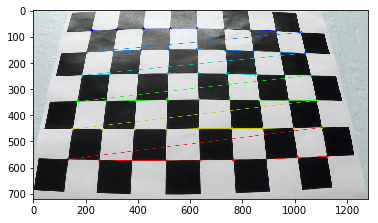

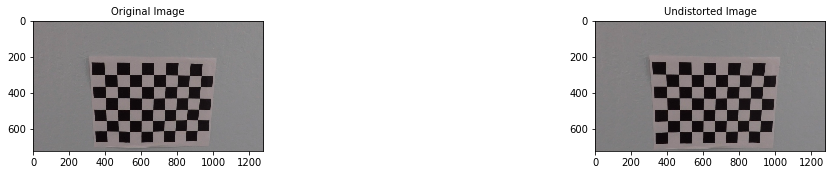

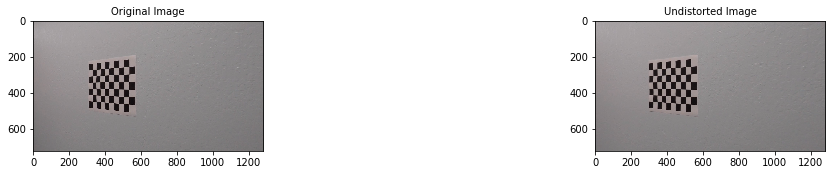

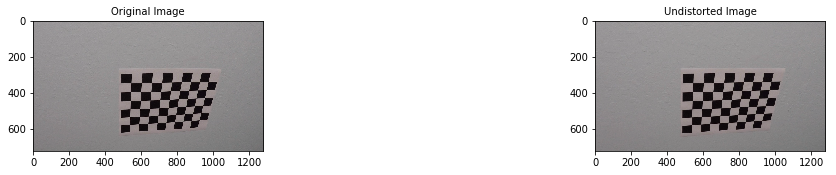

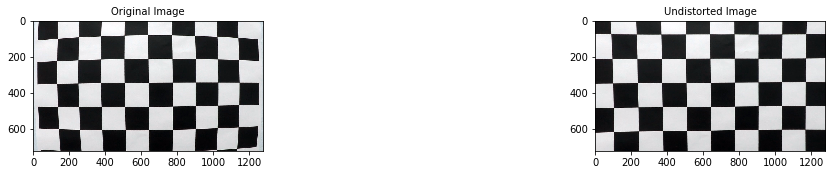

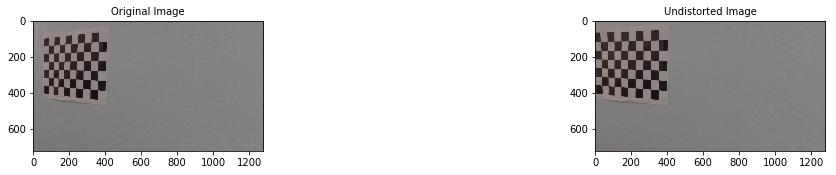

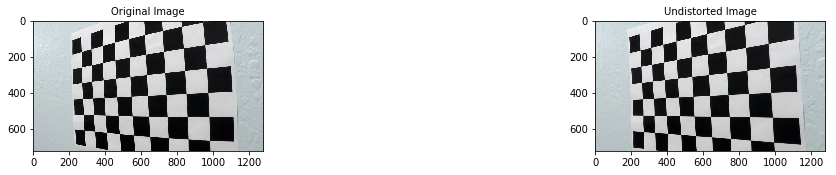

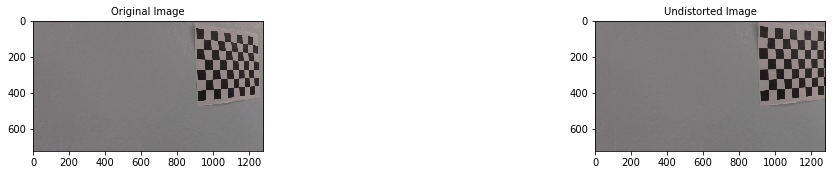

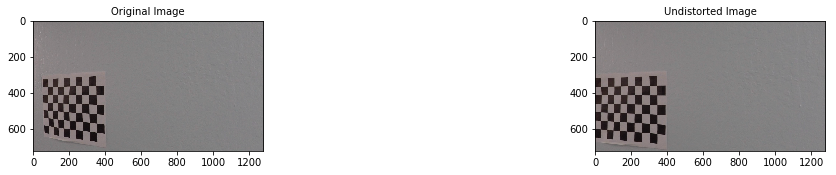

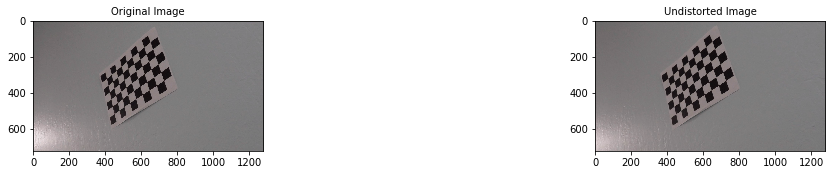

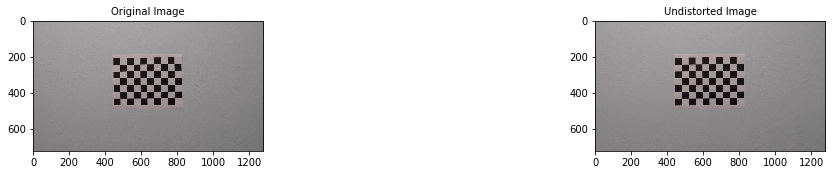

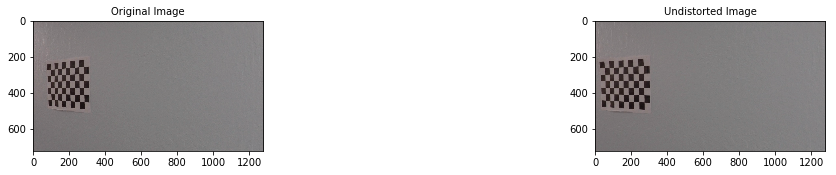

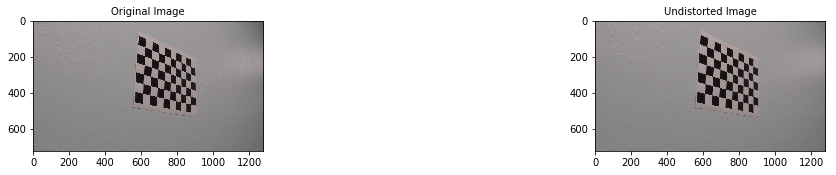

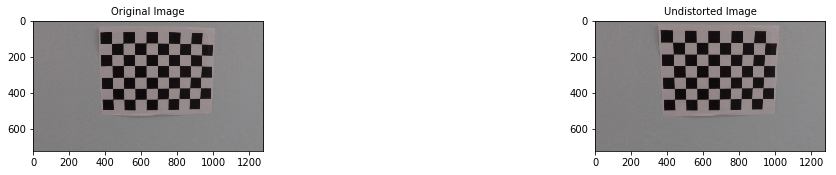

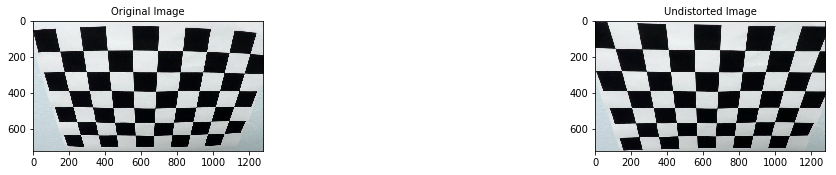

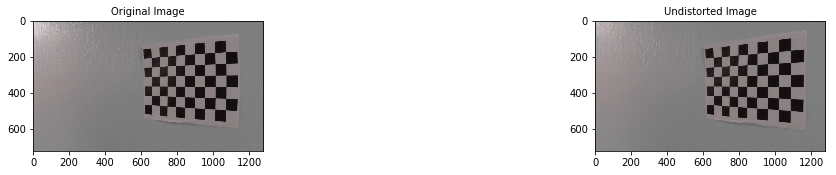

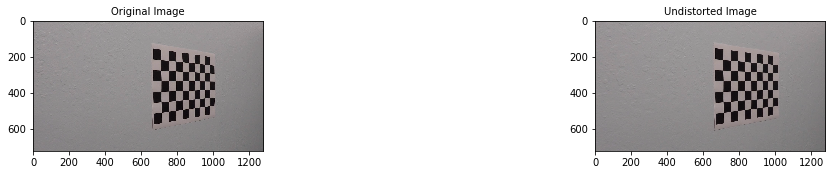

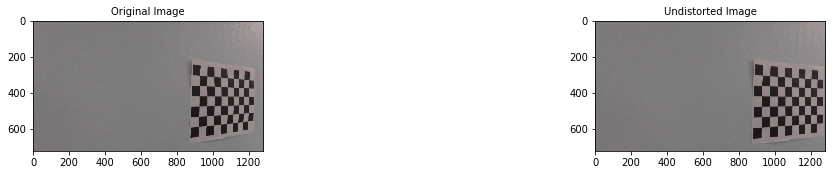

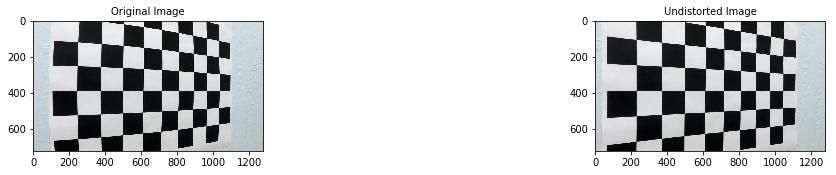

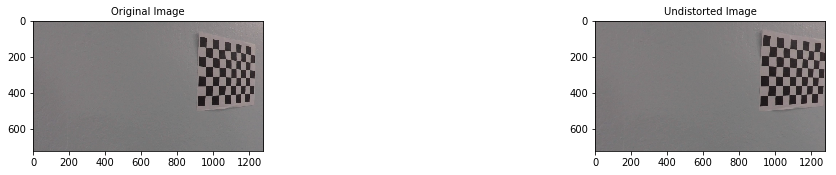

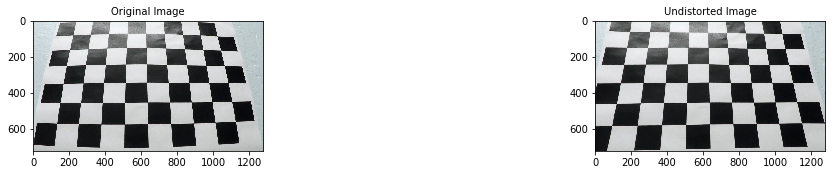

In [6]:
ret, mtx, dist, rvecs, tvecs = calibrate_and_undistort('./camera_cal/calibration*.jpg');

In [8]:
print(dist)

[[-0.21928945 -0.17895667 -0.00082145  0.00029474  0.25827251]]


In [9]:
print(mtx)

[[  1.15573551e+03   0.00000000e+00   6.66313143e+02]
 [  0.00000000e+00   1.15031737e+03   3.86541797e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [9]:
# Save camera matrices
pickle.dump(dist, open("./intermediate_objects/distortion.p", "wb"))
pickle.dump(mtx, open("./intermediate_objects/camera_matrix.p", "wb"))

In [7]:
dist = pickle.load(open("./intermediate_objects/distortion.p", "rb"))
mtx = pickle.load(open("./intermediate_objects/camera_matrix.p", "rb"))
print(dist)
print(mtx)

[[-0.21928945 -0.17895667 -0.00082145  0.00029474  0.25827251]]
[[  1.15573551e+03   0.00000000e+00   6.66313143e+02]
 [  0.00000000e+00   1.15031737e+03   3.86541797e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


# Warp Perspective

In [8]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # 4) If corners found: 
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([
            corners[0][0], 
            corners[nx-1][0], 
            corners[nx * (ny - 1)][0], 
            corners[(nx * ny) - 1][0]])
        
        #Note: you could pick any four of the detected corners 
        # as long as those four corners define a rectangle
        #One especially smart way to do this would be to use four well-chosen
        # corners that were automatically detected during the undistortion steps
        #We recommend using the automatic detection of corners in your code
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (img.shape[1], img.shape[0])
        dst = np.float32([
            [offset, offset],
            [img_size[0] - offset, offset],
            [offset, img_size[1] - offset],
            [img_size[0] - offset, img_size[1] - offset]
        ])
        
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        return warped, M
        
    #delete the next two lines
    M = None
    warped = np.copy(undist) 
    return warped, M

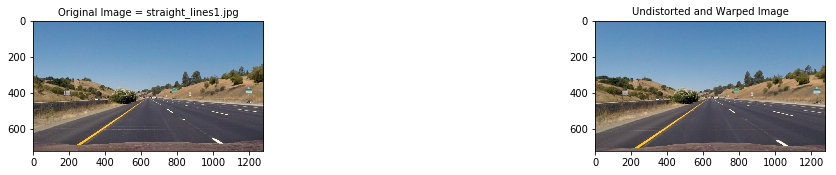

In [9]:
def corners_unwarp_from_path(path, mtx, dist):
    images = glob.glob(path)
    nx = 9
    ny = 6
    for fname in images:
        img = readImage(fname)
        top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image = ' + fname.split('/')[2], fontsize=10)
        ax2.imshow(top_down)
        ax2.set_title('Undistorted and Warped Image', fontsize=10)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        cv2.imwrite('./output_images/warped_images/' + fname.split('/')[2], top_down)

corners_unwarp_from_path('./test_images/straight_lines1.jpg', mtx, dist)


In [240]:
def corners_unwarp_lane(img, mtx, dist, src=None, dst=None, overlay_line_markings=True):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray = undist #cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    if src is None:
        src = np.float32([
            [251, 685], 
            [595, 450], 
            [686, 450], 
            [1054, 685]
        ])

    #Note: you could pick any four of the detected corners 
    # as long as those four corners define a rectangle
    #One especially smart way to do this would be to use four well-chosen
    # corners that were automatically detected during the undistortion steps
    #We recommend using the automatic detection of corners in your code
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    offset = 100
    img_size = (img.shape[1], img.shape[0])
    if dst is None:
        dst=np.float32([
            [320, 720],
            [320, 0],
            [960, 0],
            [960, 720]
        ])

    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    # f) Mark lane lines on original and warped images
    if overlay_line_markings:
        # Draw Polygon on lane lines in original image
        original_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        cv2.line(original_image, 
                 (src[0][0].astype(int), src[0][1].astype(int)), 
                 (src[1][0].astype(int), src[1][1].astype(int)), 
                 [255, 0, 0], 
                 10)
        cv2.line(original_image, 
                 (src[1][0].astype(int), src[1][1].astype(int)), 
                 (src[2][0].astype(int), src[2][1].astype(int)), 
                 [255, 0, 0], 
                 10)
        cv2.line(original_image, 
                 (src[2][0].astype(int), src[2][1].astype(int)), 
                 (src[3][0].astype(int), src[3][1].astype(int)), 
                 [255, 0, 0], 
                 10)
        cv2.line(original_image, 
                 (src[3][0].astype(int), src[3][1].astype(int)), 
                 (src[0][0].astype(int), src[0][1].astype(int)), 
                 [255, 0, 0], 
                 10)
        original_image = weighted_img(original_image, img)

        # Draw lines on lane lines in warped image
        warped_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        cv2.line(warped_image, 
                 (dst[0][0].astype(int), dst[0][1].astype(int)), 
                 (dst[1][0].astype(int), dst[1][1].astype(int)), 
                 [255, 0, 0], 
                 10)
        cv2.line(warped_image, 
                 (dst[2][0].astype(int), dst[2][1].astype(int)), 
                 (dst[3][0].astype(int), dst[3][1].astype(int)), 
                 [255, 0, 0], 
                 10)
        warped_image = weighted_img(warped_image, warped)

        return original_image, warped_image
    return img, warped, M

In [241]:
def plot_warped_images_lane(original_image, warped_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
    f.tight_layout()
    ax1.imshow(original_image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [242]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [243]:
def corners_unwarp_lane_from_path(path, mtx, dist, src=None, dst=None):
    images = glob.glob(path)
    for fname in images:
        img = readImage(fname)
        original_image, warped_image = corners_unwarp_lane(img, mtx, dist, src, overlay_line_markings=True)      
        plot_warped_images_lane(original_image, warped_image)        

In [244]:
def corners_unwarp_lane_from_path_interact(path, 
                                      x1=251, y1=685, 
                                      x2=595, y2=450, 
                                      x3=686, y3=450, 
                                      x4=1054, y4=685):
    src = np.float32([
        [x1, y1], 
        [x2, y2], 
        [x3, y3], 
        [x4, y4]
    ])
    dst = np.float32(dst=np.float32([
            [320, 720],
            [320, 0],
            [960, 0],
            [960, 720]
        ]))
    corners_unwarp_lane_from_path(path, mtx, dist, src, dst)

In [245]:
interact_manual(corners_unwarp_lane_from_path_interact, path='./test_images/straight_lines1.jpg', 
                x1=(0, 1280), y1=(0, 720),
                x2=(0, 1280), y2=(0, 720),
                x3=(0, 1280), y3=(0, 720),
                x4=(0, 1280), y4=(0, 720),
)

interactive(children=(Text(value='./test_images/straight_lines1.jpg', description='path'), IntSlider(value=251, description='x1', max=1280), IntSlider(value=685, description='y1', max=720), IntSlider(value=595, description='x2', max=1280), IntSlider(value=450, description='y2', max=720), IntSlider(value=686, description='x3', max=1280), IntSlider(value=450, description='y3', max=720), IntSlider(value=1054, description='x4', max=1280), IntSlider(value=685, description='y4', max=720), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.corners_unwarp_lane_from_path_interact(path, x1=251, y1=685, x2=595, y2=450, x3=686, y3=450, x4=1054, y4=685)>

# Gradient Threshold

In [16]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(45,120)):    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    absSobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaledSobel = np.uint8(255 * absSobel / np.max(absSobel))
    
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaledSobel)
    sbinary[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
    
    return scaledSobel

In [17]:
def mag_thresh(gray, sobel_kernel=5, mag_thresh=(21, 221)):
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel = np.sqrt(np.square(sobelX) + np.square(sobelY))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaledSobel = np.uint8(255 * sobel / np.max(sobel))
    
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaledSobel)
    sbinary[(scaledSobel >= mag_thresh[0]) & (scaledSobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return sbinary

In [18]:
def dir_threshold(gray, sobel_kernel=5, thresh=(0.6, 1.3)):
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    absSobelX = np.absolute(sobelX)
    absSobelY = np.absolute(sobelY)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel = np.arctan2(absSobelY, absSobelX)
    
    # 5) Create a binary mask where direction thresholds are met
    sobelBinary = np.zeros_like(sobel)
    sobelBinary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return sobelBinary

In [19]:
def plot_img_on_ax(ax, img, title):
    if len(img.shape) == 3:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=15)

In [20]:
def plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined):
    # Plot the result
    f, ax = plt.subplots(2, 3, figsize=(10, 5))
    f.tight_layout()
    print(ax.shape)
    
    plot_img_on_ax(ax[0][0], img, 'Original Image')
    plot_img_on_ax(ax[0][1], gradx, 'Absolute Gradient X')
    plot_img_on_ax(ax[0][2], grady, 'Absolute Gradient Y')
    plot_img_on_ax(ax[1][0], mag_binary, 'Magnitude of Gradient')
    plot_img_on_ax(ax[1][1], dir_binary, 'Direction of Gradient')
    plot_img_on_ax(ax[1][2], combined, 'Combined')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [21]:
def gradient_thresholding(image, kernel_size=5, 
                abs_thresh_min=45, abs_thresh_max=120,
                mag_thresh_min=21, mag_thresh_max=221,
                dir_thresh_min=0.6, dir_thresh_max=1.3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=kernel_size, thresh=(abs_thresh_min, abs_thresh_max))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=kernel_size, thresh=(abs_thresh_min, abs_thresh_max))
    mag_binary = mag_thresh(gray, sobel_kernel=kernel_size, mag_thresh=(mag_thresh_min, mag_thresh_max))
    dir_binary = dir_threshold(gray, sobel_kernel=kernel_size, thresh=(dir_thresh_min, dir_thresh_max))
    
    combined_gradient_thresholds = np.zeros_like(dir_binary)
    combined_gradient_thresholds[((gradx == 1) & (grady == 1)) | ((mag_binary == 1))] = 1
    return gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds

In [22]:
def gradient_thresholding_interact(image_name, kernel_size=5, 
                abs_thresh_min=45, abs_thresh_max=120,
                mag_thresh_min=21, mag_thresh_max=221,
                dir_thresh_min=0.6, dir_thresh_max=1.3):
    print(kernel_size, abs_thresh_min, abs_thresh_max, mag_thresh_min, mag_thresh_max, dir_thresh_min, dir_thresh_max)
    print(image_name)
    image = readImage(image_name)
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(image, kernel_size, abs_thresh_min, abs_thresh_max, mag_thresh_min, mag_thresh_max, dir_thresh_min, dir_thresh_max)
    pickle.dump(combined_gradient_thresholds, open("./intermediate_objects/combined_gradient_thresholds.p", "wb"))
    plot_threshold_gradient(image, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)

# Color Threshold

In [23]:
def plot_threshold_color(img, h_channel, l_channel, s_channel, combined):
    # Plot the result
    f, ax = plt.subplots(1, 5, figsize=(15, 9))
    f.tight_layout()
    print(ax.shape)
    
    plot_img_on_ax(ax[0], img, 'Original Image')
    plot_img_on_ax(ax[1], h_channel, 'H Channel')
    plot_img_on_ax(ax[2], l_channel, 'L Channel')
    plot_img_on_ax(ax[3], s_channel, 'S Channel')
    plot_img_on_ax(ax[4], combined, 'Combined')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [24]:
def channel_threshold(channel, thresh=(15, 200)):    
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

In [25]:
def color_thresholding_rgb(img, r_thresh_min=39, r_thresh_max=215,
                      g_thresh_min=47, g_thresh_max=222,
                      b_thresh_min=44, b_thresh_max=132):
    r_channel = channel_threshold(img[:,:,0], thresh=(r_thresh_min, r_thresh_max))
    g_channel = channel_threshold(img[:,:,1], thresh=(g_thresh_min, g_thresh_max))
    b_channel = channel_threshold(img[:,:,2], thresh=(b_thresh_min, b_thresh_max))
    
    combined_color_thresholds = np.zeros_like(r_channel)
    combined_color_thresholds[((r_channel == 1) & (g_channel == 1) & (b_channel == 1))] = 255
    return r_channel, g_channel, b_channel, combined_color_thresholds

In [55]:
def color_thresholding_hls(img, h_thresh_min=15, h_thresh_max=100,
                      l_thresh_min=15, l_thresh_max=200,
                      s_thresh_min=90, s_thresh_max=255):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = channel_threshold(hls[:,:,0], thresh=(h_thresh_min, h_thresh_max))
    l_channel = channel_threshold(hls[:,:,1], thresh=(l_thresh_min, l_thresh_max))
    s_channel = channel_threshold(hls[:,:,2], thresh=(s_thresh_min, s_thresh_max))
    
    combined_color_thresholds = np.zeros_like(h_channel)
    combined_color_thresholds[((h_channel == 1) & (s_channel == 1))] = 255
    return h_channel, l_channel, s_channel, combined_color_thresholds

In [68]:
def color_thresholding_hsv(img, h_thresh_min=15, h_thresh_max=100,
                      s_thresh_min=15, s_thresh_max=200,
                      v_thresh_min=90, v_thresh_max=255):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    h_channel = channel_threshold(hsv[:,:,0], thresh=(h_thresh_min, h_thresh_max))
    s_channel = channel_threshold(hsv[:,:,1], thresh=(s_thresh_min, s_thresh_max))
    v_channel = channel_threshold(hsv[:,:,2], thresh=(v_thresh_min, v_thresh_max))
    
    combined_color_thresholds = np.zeros_like(h_channel)
    combined_color_thresholds[((h_channel == 1) & (s_channel == 1))] = 255
    return h_channel, s_channel, v_channel, combined_color_thresholds

In [27]:
def color_thresholding_interact_rgb(image_name, r_thresh_min=39, r_thresh_max=215,
                      g_thresh_min=47, g_thresh_max=222,
                      b_thresh_min=44, b_thresh_max=132):
    print(r_thresh_min, r_thresh_max, g_thresh_min, g_thresh_max, b_thresh_min, b_thresh_max)
    img = readImage(image_name)
    r_channel, g_channel, b_channel, combined_color_thresholds = color_thresholding_rgb(img, r_thresh_min, r_thresh_max, g_thresh_min, g_thresh_max, b_thresh_min, b_thresh_max)
    pickle.dump(combined_color_thresholds, open("./intermediate_objects/combined_color_thresholds_rgb.p", "wb"))
    plot_threshold_color(img, r_channel, g_channel, b_channel, combined_color_thresholds)

In [57]:
def color_thresholding_interact_hls(image_name, h_thresh_min=15, h_thresh_max=100,
                      l_thresh_min=15, l_thresh_max=200,
                      s_thresh_min=90, s_thresh_max=255):
    print(h_thresh_min, h_thresh_max, l_thresh_min, l_thresh_max, s_thresh_min, s_thresh_max)
    img = readImage(image_name)
    h_channel, l_channel, s_channel, combined_color_thresholds = color_thresholding_hls(img, h_thresh_min, h_thresh_max, l_thresh_min, l_thresh_max, s_thresh_min, s_thresh_max)
    pickle.dump(combined_color_thresholds, open("./intermediate_objects/combined_color_thresholds_hls.p", "wb"))
    plot_threshold_color(img, h_channel, l_channel, s_channel, combined_color_thresholds)

In [59]:
def color_thresholding_interact_hsv(image_name, h_thresh_min=15, h_thresh_max=100,
                      s_thresh_min=15, s_thresh_max=200,
                      v_thresh_min=90, v_thresh_max=255):
    print(h_thresh_min, h_thresh_max, s_thresh_min, s_thresh_max, v_thresh_min, v_thresh_max)
    img = readImage(image_name)
    h_channel, s_channel, v_channel, combined_color_thresholds = color_thresholding_hsv(img, h_thresh_min, h_thresh_max, s_thresh_min, s_thresh_max, v_thresh_min, v_thresh_max)
    pickle.dump(combined_color_thresholds, open("./intermediate_objects/combined_color_thresholds_hsv.p", "wb"))
    plot_threshold_color(img, h_channel, s_channel, v_channel, combined_color_thresholds)

# Color + Gradient Threshold

In [29]:
# Edit this function to create your own pipeline.
def combined_color_gradient_thresholding(img, combined_gradient_thresholds, 
                                         combined_color_thresholds_rgb, combined_color_thresholds_hls):
    
    # Stack each channel    
    combined = np.zeros_like(combined_gradient_thresholds)
    combined[((combined_gradient_thresholds == 1) | (combined_color_thresholds_rgb == 1) & (combined_color_thresholds_hls))] = 255
    return combined
    
    #color_binary = np.dstack((np.zeros_like(combined_gradient_thresholds), 
    #                          combined_gradient_thresholds, 
    #                         combined_color_thresholds)) * 255
    #return color_binary

In [108]:
image_name = './test_images/bug0.jpg'

In [109]:
interact_manual(gradient_thresholding_interact, image_name=image_name, kernel_size=(3, 19, 2), 
         abs_thresh_min=(0, 255), abs_thresh_max=(0, 255), 
         mag_thresh_min=(0, 255), mag_thresh_max=(0, 255),
         dir_thresh_min=(0, 1.57), dir_thresh_max=(0, 1.57))

interactive(children=(Text(value='./test_images/bug0.jpg', description='image_name'), IntSlider(value=5, description='kernel_size', max=19, min=3, step=2), IntSlider(value=45, description='abs_thresh_min', max=255), IntSlider(value=120, description='abs_thresh_max', max=255), IntSlider(value=21, description='mag_thresh_min', max=255), IntSlider(value=221, description='mag_thresh_max', max=255), FloatSlider(value=0.6, description='dir_thresh_min', max=1.57), FloatSlider(value=1.3, description='dir_thresh_max', max=1.57), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.gradient_thresholding_interact(image_name, kernel_size=5, abs_thresh_min=45, abs_thresh_max=120, mag_thresh_min=21, mag_thresh_max=221, dir_thresh_min=0.6, dir_thresh_max=1.3)>

In [110]:
interact_manual(color_thresholding_interact_rgb, image_name=image_name,
               r_thresh_min=(0, 255), r_thresh_max=(0, 255),
               g_thresh_min=(0, 255), g_thresh_max=(0, 255),
               b_thresh_min=(0, 255), b_thresh_max=(0, 255))

interactive(children=(Text(value='./test_images/bug0.jpg', description='image_name'), IntSlider(value=39, description='r_thresh_min', max=255), IntSlider(value=215, description='r_thresh_max', max=255), IntSlider(value=47, description='g_thresh_min', max=255), IntSlider(value=222, description='g_thresh_max', max=255), IntSlider(value=44, description='b_thresh_min', max=255), IntSlider(value=132, description='b_thresh_max', max=255), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.color_thresholding_interact_rgb(image_name, r_thresh_min=39, r_thresh_max=215, g_thresh_min=47, g_thresh_max=222, b_thresh_min=44, b_thresh_max=132)>

In [111]:
interact_manual(color_thresholding_interact_hls, image_name=image_name,
               h_thresh_min=(0, 255), h_thresh_max=(0, 255),
               l_thresh_min=(0, 255), l_thresh_max=(0, 255),
               s_thresh_min=(0, 255), s_thresh_max=(0, 255))

interactive(children=(Text(value='./test_images/bug0.jpg', description='image_name'), IntSlider(value=15, description='h_thresh_min', max=255), IntSlider(value=100, description='h_thresh_max', max=255), IntSlider(value=15, description='l_thresh_min', max=255), IntSlider(value=200, description='l_thresh_max', max=255), IntSlider(value=90, description='s_thresh_min', max=255), IntSlider(value=255, description='s_thresh_max', max=255), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.color_thresholding_interact_hls(image_name, h_thresh_min=15, h_thresh_max=100, l_thresh_min=15, l_thresh_max=200, s_thresh_min=90, s_thresh_max=255)>

In [112]:
interact_manual(color_thresholding_interact_hsv, image_name=image_name,
               h_thresh_min=(0, 255), h_thresh_max=(0, 255),
               s_thresh_min=(0, 255), s_thresh_max=(0, 255),
               v_thresh_min=(0, 255), v_thresh_max=(0, 255))

interactive(children=(Text(value='./test_images/bug0.jpg', description='image_name'), IntSlider(value=15, description='h_thresh_min', max=255), IntSlider(value=100, description='h_thresh_max', max=255), IntSlider(value=15, description='s_thresh_min', max=255), IntSlider(value=200, description='s_thresh_max', max=255), IntSlider(value=90, description='v_thresh_min', max=255), IntSlider(value=255, description='v_thresh_max', max=255), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.color_thresholding_interact_hsv(image_name, h_thresh_min=15, h_thresh_max=100, s_thresh_min=15, s_thresh_max=200, v_thresh_min=90, v_thresh_max=255)>

In [34]:
def make_multichannel(image):
    return np.uint8(np.dstack([image, image, image]))

In [35]:
image_name = './test_images/straight_lines1.jpg'
img = readImage(image_name)

combined_gradient_thresholds = pickle.load(open("./intermediate_objects/combined_gradient_thresholds.p", "rb"))
combined_color_thresholds_rgb = pickle.load(open("./intermediate_objects/combined_color_thresholds_rgb.p", "rb"))
combined_color_thresholds_hls = pickle.load(open("./intermediate_objects/combined_color_thresholds_hls.p", "rb"))

combined = combined_color_gradient_thresholding(img, combined_gradient_thresholds, combined_color_thresholds_rgb, combined_color_thresholds_hls)
merged = cv2.addWeighted(img, 1.0, make_multichannel(combined), 0.7, 0)
plt.imshow(combined_color_thresholds)

NameError: name 'combined_color_thresholds' is not defined

## Sliding Window

In [297]:
def warp_and_threshold(img):
    original_image, warped_image, M = corners_unwarp_lane(img, mtx, dist, overlay_line_markings=False, dst=np.float32([
            [320, 720],
            [320, 0],
            [960, 0],
            [960, 720]
        ]))      
    #plot_warped_images_lane(original_image, warped_image)  
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(warped_image)
    
    r_channel, g_channel, b_channel, combined_color_thresholds_rgb = color_thresholding_rgb(warped_image)    
    
    h_channel, l_channel, s_channel, combined_color_thresholds_hls = color_thresholding_hls(warped_image)
    
    combined_color_thresholds = np.zeros_like(h_channel)
    combined_color_thresholds[((h_channel == 1) & (s_channel == 1)) | 
                              ((r_channel == 0) & (b_channel == 1)) |
                              ((mag_binary == 1) & (dir_binary == 1)) | 
                              ((gradx == 1) & (grady == 1))] = 1
    
    combined = combined_color_gradient_thresholding(warped_image, combined_gradient_thresholds, 
                                                    combined_color_thresholds_rgb, combined_color_thresholds_hls)
    
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    #plot_threshold_color(img, r_channel, g_channel, b_channel, combined_color_thresholds_rgb)
    #plot_threshold_color(img, h_channel, l_channel, s_channel, combined_color_thresholds)
    
    # combined = combined_color_gradient_thresholding(img, combined_gradient_thresholds, combined_color_thresholds)
    # merged = cv2.addWeighted(img, 1.0, make_multichannel(combined), 0.7, 0)
    # plt.imshow(combined_color_thresholds)
    
    
    print(combined.shape)
    return combined_color_thresholds

(720, 1280)


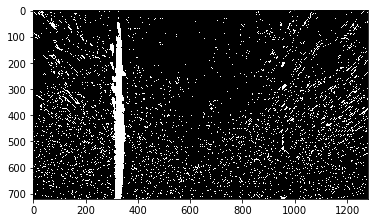

In [298]:
image_name = './test_images/straight_lines1.jpg'
img = readImage(image_name)
warp_and_threshold_result = warp_and_threshold(img)
plt.imshow(warp_and_threshold_result, cmap='gray')

In [250]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(midpoint, leftx_base, rightx_base)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [251]:
def fit_polynomial(binary_warped, is_plot_required=True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if is_plot_required:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_pts = np.vstack((left_fitx,ploty)).astype(np.int32).T
    right_pts = np.vstack((right_fitx,ploty)).astype(np.int32).T

    return out_img, left_pts, right_pts, left_fit, right_fit

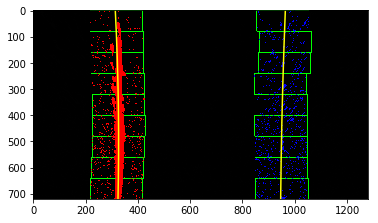

In [299]:
sliding_window_result, left_pts, right_pts, left_fit, right_fit = fit_polynomial(warp_and_threshold_result)
plt.imshow(sliding_window_result)

In [332]:
def get_distance(left_fit, right_fit, max_y):
    max_y = 720
    left = left_fit[0]*max_y**2 + left_fit[1]*max_y + left_fit[2]
    right = right_fit[0]*max_y**2 + right_fit[1]*max_y + right_fit[2]
    distance = right-left
    return distance

In [333]:
def pipeline(img):    
    original_image, warped_image, M = corners_unwarp_lane(img, mtx, dist, overlay_line_markings=False, dst=np.float32([
            [320, 720],
            [320, 0],
            [960, 0],
            [960, 720]
        ]))      
    # plot_warped_images(original_image, warped_image)  
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(warped_image)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(warped_image)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    r_channel, g_channel, b_channel, combined_color_thresholds_rgb = color_thresholding_rgb(warped_image)
    # plot_threshold_color(img, r_channel, g_channel, b_channel, combined_color_thresholds_rgb)
    
    h_channel, l_channel, s_channel, combined_color_thresholds = color_thresholding_hls(warped_image)
    
    combined_color_thresholds = np.zeros_like(h_channel)
    combined_color_thresholds[((h_channel == 1) & (s_channel == 1)) | 
                              ((r_channel == 0) & (b_channel == 1)) |
                              ((mag_binary == 1) & (dir_binary == 1)) | 
                              ((gradx == 1) & (grady == 1))] = 1
    # plot_threshold_color(img, h_channel, l_channel, s_channel, combined_color_thresholds)
    
    sliding_window_result, left_pts, right_pts, left_fit, right_fit = fit_polynomial(combined_color_thresholds, False)    
    # plt.imshow(sliding_window_result)
    
    distance = get_distance(left_fit, right_fit, 720)
    
    print(sliding_window_result.shape)
    cv2.polylines(sliding_window_result,  [left_pts],  False,  (255, 255, 255),  10)
    cv2.polylines(sliding_window_result,  [right_pts],  False,  (255, 255, 255),  10)
    
    return sliding_window_result

In [334]:
def plot_sliding_window_result(original_img, result_img):
    # Plot the result
    f, ax = plt.subplots(1, 2, figsize=(15, 9))
    f.tight_layout()
    
    plot_img_on_ax(ax[0], original_img, 'Original Image')
    plot_img_on_ax(ax[1], result_img, 'Sliding Window')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280, 3)


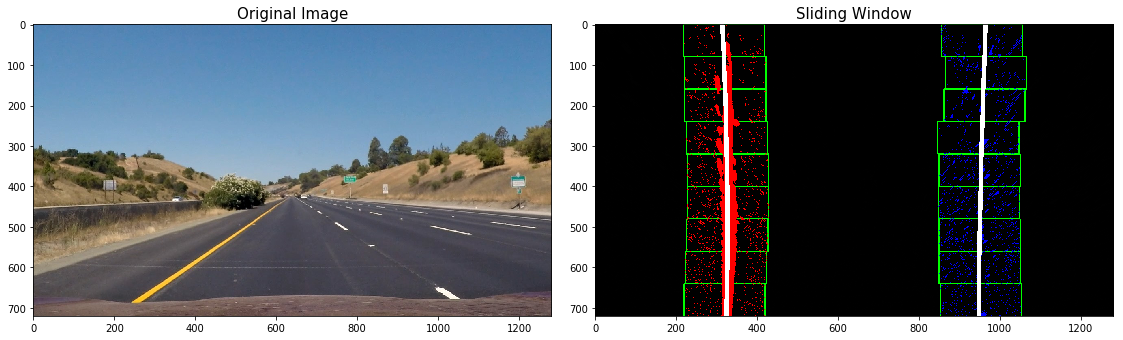

In [335]:
image_name = './test_images/straight_lines1.jpg'
img = readImage(image_name)
result = pipeline(img)
plot_sliding_window_result(img, result)

# Sliding Window Warp

In [284]:
def pipeline(img):    
    original_image, undist, M = corners_unwarp_lane(img, mtx, dist, overlay_line_markings=False, dst=np.float32([
            [320, 720],
            [320, 0],
            [960, 0],
            [960, 720]
        ]))      
    # plot_warped_images(original_image, warped_image)  
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(undist)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(undist)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    r_channel, g_channel, b_channel, combined_color_thresholds_rgb = color_thresholding_rgb(undist)
    plot_threshold_color(img, r_channel, g_channel, b_channel, combined_color_thresholds_rgb)
    
    h_channel, l_channel, s_channel, combined_color_thresholds = color_thresholding_hls(undist)
    plot_threshold_color(img, h_channel, l_channel, s_channel, combined_color_thresholds_hls)
    
    combined_color_thresholds = np.zeros_like(h_channel)
    combined_color_thresholds[((h_channel == 1) & (s_channel == 1)) | 
                              ((r_channel == 0) & (b_channel == 1)) |
                              ((mag_binary == 1) & (dir_binary == 1)) | 
                              ((gradx == 1) & (grady == 1))] = 1    
    
    sliding_window_result, left_pts, right_pts, left_fit, right_fit = fit_polynomial(combined_color_thresholds, False)    
    plt.imshow(sliding_window_result)
    
    # Plot points
    ploty = np.linspace(0, combined_color_thresholds.shape[0]-1, combined_color_thresholds.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_color_thresholds).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    print(color_warp.shape)
    
     # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
     # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)

    return result

(5,)
(5,)
(720, 1280, 3)


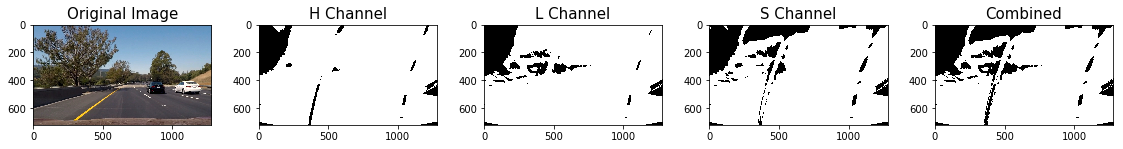

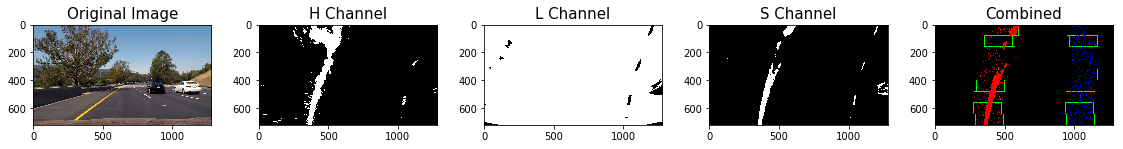

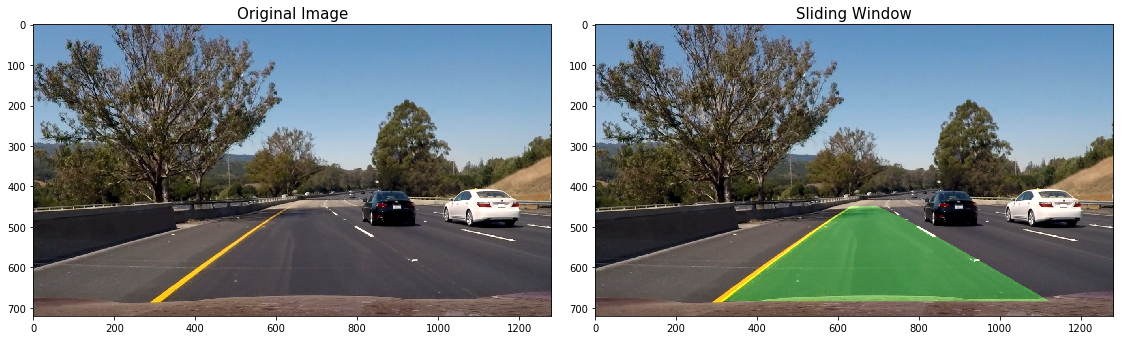

In [292]:
image_name = './test_images/test6.jpg'
img = readImage(image_name)
result = pipeline(img)
plot_sliding_window_result(img, result)

# Measuring Curvature

In [293]:
def measure_curvature_real(img):
    original_image, undist, M = corners_unwarp_lane(img, mtx, dist, overlay_line_markings=False, dst=np.float32([
            [320, 720],
            [320, 0],
            [960, 0],
            [960, 720]
        ]))
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(undist)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(undist)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    r_channel, g_channel, b_channel, combined_color_thresholds_rgb = color_thresholding_rgb(undist)
    #plot_threshold_color(img, r_channel, g_channel, b_channel, combined_color_thresholds_rgb)
    
    h_channel, l_channel, s_channel, combined_color_thresholds = color_thresholding_hls(undist)
    #plot_threshold_color(img, h_channel, l_channel, s_channel, combined_color_thresholds_hls)
    
    combined_color_thresholds = np.zeros_like(h_channel)
    combined_color_thresholds[((h_channel == 1) & (s_channel == 1)) | 
                              ((r_channel == 0) & (b_channel == 1)) |
                              ((mag_binary == 1) & (dir_binary == 1)) | 
                              ((gradx == 1) & (grady == 1))] = 1    
    
    sliding_window_result, left_pts, right_pts, left_fit, right_fit = fit_polynomial(combined_color_thresholds, False)
    
    return measure_curvature_and_distance(combined_color_thresholds, left_fit, right_fit)

In [263]:
def measure_curvature_and_distance(img, left_fit, right_fit):
    # Plot points
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
     # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    # Implement the calculation of R_curve (radius of curvature)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curvature = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**(3/2)) / abs(2 * left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curvature = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**(3/2)) / abs(2 * right_fit_cr[0])  ## Implement the calculation of the right line here
    
    left_lanex = left_fit_cr[0] * y_eval**2 * ym_per_pix + left_fit_cr[1] * y_eval + left_fit_cr[2]
    right_lanex = right_fit_cr[0] * y_eval**2 * ym_per_pix + right_fit_cr[1] * y_eval + right_fit_cr[2]
    lane_center = (left_lanex + right_lanex) / 2.0
    lane_center_offset = (lane_center - img.shape[1] * xm_per_pix)
    
    return left_curvature, right_curvature, lane_center

In [264]:
# Calculate the radius of curvature in pixels for both lane lines
image_name = './test_images/straight_lines1.jpg'
img = readImage(image_name)
left_curverad, right_curverad, lane_center = measure_curvature_real(img)

print(left_curverad, right_curverad, lane_center)

4433.89963612 3088.40920831 4.18788214568


# Pipeline

In [415]:
def final_pipeline(img, line):    
    original_image, undist, M = corners_unwarp_lane(img, mtx, dist, overlay_line_markings=False, dst=np.float32([
            [320, 720],
            [320, 0],
            [960, 0],
            [960, 720]
        ]))
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(undist)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds = gradient_thresholding(undist)
    # plot_threshold_gradient(img, gradx, grady, mag_binary, dir_binary, combined_gradient_thresholds)
    
    r_channel, g_channel, b_channel, combined_color_thresholds_rgb = color_thresholding_rgb(undist)
    #plot_threshold_color(img, r_channel, g_channel, b_channel, combined_color_thresholds_rgb)
    
    h_channel, l_channel, s_channel, combined_color_thresholds = color_thresholding_hls(undist)
    #plot_threshold_color(img, h_channel, l_channel, s_channel, combined_color_thresholds_hls)
    
    combined_color_thresholds = np.zeros_like(h_channel)
    combined_color_thresholds[((h_channel == 1) & (s_channel == 1)) | 
                              ((r_channel == 0) & (b_channel == 1)) |
                              ((mag_binary == 1) & (dir_binary == 1)) | 
                              ((gradx == 1) & (grady == 1))] = 1    
    
    sliding_window_result, left_pts, right_pts, left_fit, right_fit = fit_polynomial(combined_color_thresholds, False)    
    
    # Plot points
    ploty = np.linspace(0, combined_color_thresholds.shape[0]-1, combined_color_thresholds.shape[0])
    
    left_fit, right_fit = line.get_fit(left_fit, right_fit, 720)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_color_thresholds).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], original_image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    left_curvature, right_curvature, lane_center = measure_curvature_and_distance(combined_color_thresholds, left_fit, right_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Left Curvature = ' + str(left_curvature) + ' m '
    cv2.putText(result, text,(10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    text = 'Right Curvature = ' + str(right_curvature) + ' m '
    cv2.putText(result, text,(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    text = 'Lane Center ' + str(lane_center) + ' m '
    cv2.putText(result, text,(10,150), font, 1,(255,255,255),2,cv2.LINE_AA)

    return result

0.0
0.0


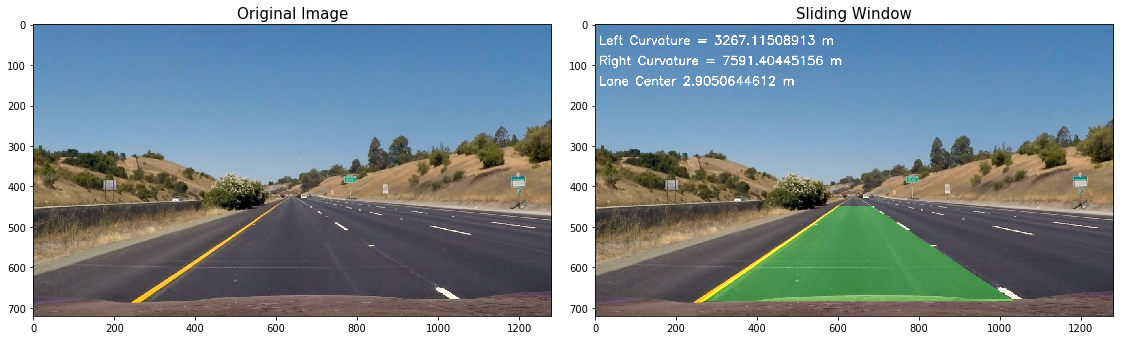

In [417]:
image_name = './test_images/straight_lines1.jpg'
img = readImage(image_name)
result = final_pipeline(img, Line())
plot_sliding_window_result(img, result)

In [418]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [427]:
class Line():
    def __init__(self):
        self.previous_left_fit = None
        self.previous_right_fit = None
    
    def get_fit(self, left_fit, right_fit, max_y):
        if self.previous_left_fit is None:
            self.previous_left_fit = left_fit
        if self.previous_right_fit is None:
            self.previous_right_fit = right_fit
        
        new_left_x = left_fit[0]*max_y**2 + left_fit[1]*max_y + left_fit[2]
        new_right_x = right_fit[0]*max_y**2 + right_fit[1]*max_y + right_fit[2]
        
        previous_left_x = self.previous_left_fit[0]*max_y**2 + self.previous_left_fit[1]*max_y + self.previous_left_fit[2]
        previous_right_x = self.previous_right_fit[0]*max_y**2 + self.previous_right_fit[1]*max_y + self.previous_right_fit[2]
        
        # print(abs(new_left_x - previous_left_x))
        # print(abs(new_right_x - previous_right_x))
        if (abs(new_left_x - previous_left_x) < 50):
            self.previous_left_fit = left_fit
        if (abs(new_right_x - previous_right_x) < 50):
            self.previous_right_fit = right_fit
        
        return self.previous_left_fit, self.previous_right_fit

In [428]:
line = Line()
def process_image(image):
    """
    Pipeline for returning a color image while processing a video, to draw lines on lanes.
    """
    return final_pipeline(image, line)

In [431]:
white_output = 'output_videos/project_video_test_3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(35, 48)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_test_3.mp4
[MoviePy] Writing video output_videos/project_video_test_3.mp4


100%|█████████▉| 1260/1261 [13:10<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_test_3.mp4 

CPU times: user 10min 49s, sys: 3.29 s, total: 10min 52s
Wall time: 13min 13s


In [433]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

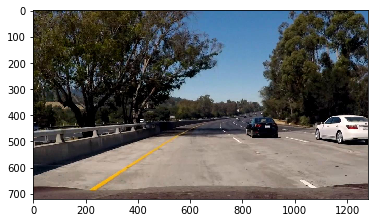

In [329]:
# clip1 = VideoFileClip("./output_videos/project_video_test_2.mp4")
clip1 = VideoFileClip("project_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
clip1.save_frame('./test_images/bug2.jpg', 41)

img = readImage('./test_images/bug2.jpg')
plt.imshow(img)